# Problem Statement

Traffic congestion is increasingly problematic in urban environments due to rising population density and urban sprawl. This congestion leads to significant delays, heightened stress, and economic losses. Despite advances in traffic monitoring and data collection, predicting traffic patterns remains a complex challenge.

The Metro Interstate Traffic Volume dataset provides detailed records of traffic flow on interstate highways, including time-stamped traffic volume measurements and various influencing factors like weather conditions, time of day, and special events. 

The core problem is to build an effective machine learning model that can accurately predict future traffic volumes. This involves selecting appropriate algorithms, fine-tuning model parameters, and validating performance to ensure reliable predictions. By accurately forecasting traffic conditions, the model aims to support better traffic management strategies, reduce congestion, and enhance overall urban mobility.

## Feature Description

- **holiday**: Categorical - US National holidays plus regional holiday, Minnesota State Fair
- **temp**: Numeric - Average temperature in Kelvin
- **rain_1h**: Numeric - Amount in mm of rain that occurred in the hour
- **snow_1h**: Numeric - Amount in mm of snow that occurred in the hour
- **clouds_all**: Numeric - Percentage of cloud cover
- **weather_main**: Categorical - Short textual description of the current weather
- **weather_description**: Categorical - Longer textual description of the current weather
- **date_time**: DateTime - Hour of the data collected in local CST time
- **traffic_volume**: Numeric - Hourly I-94 ATR 301 reported westbound traffic volume

## Loading Important Libraries

In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.model_selection import KFold
# ^^^ pyforest auto-imports - don't write above this line
# Libraries for data access and manipulation
from astrapy import DataAPIClient

# Libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline


# Libraries for data processing and machine learning
import numpy as np
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error



# Libraries for statistics and warnings management
import statistics
import warnings
warnings.filterwarnings("ignore")

## Data Ingestion

In [2]:
from astrapy import DataAPIClient
import pandas as pd

# Initialize the client
client = DataAPIClient("AstraCS:sfAYACtyAiPjGoNObLAuxRqP:88f953700b41eb41428f413b3071b6f1fefab22af5328f776b5624ec2695fd1b")

# Get the database instance
db = client.get_database_by_api_endpoint("https://3d38969d-98ef-4d54-9580-769f7c5ed3dd-us-east-2.apps.astra.datastax.com")

# Access the collection (table)
collection = db.get_collection('metrodata')  

result = collection.find({})  # Empty filter retrieves all documents

# Convert the result to a DataFrame
df1 = pd.DataFrame(result)

In [3]:
# Storing the Dataset Locally for Future Usage
df1.to_csv('Metro Interstate Traffic Volume.csv', index=False)

In [2]:
# Loading the Locally Stored Dataset 
df = pd.read_csv('Metro Interstate Traffic Volume.csv')

<IPython.core.display.Javascript object>

In [3]:
df.head()

,_id,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,8748e5b7-5940-4e81-88e5-b759407e8142,None,258.89,0.00,0.0,75,Snow,heavy snow,2013-02-20 02:00:00,220
1,1da8337e-2569-4208-a833-7e256942089d,None,288.01,0.00,0.0,1,Clear,sky is clear,2018-09-09 23:00:00,996
2,87ae4c94-264b-4e42-ae4c-94264b9e426a,None,290.65,0.76,0.0,64,Rain,moderate rain,2013-07-31 01:00:00,402
3,ecce0631-32ee-4500-8e06-3132eea5008a,None,290.78,0.00,0.0,75,Clouds,broken clouds,2018-09-09 11:00:00,4273
4,346a7b77-6382-4830-aa7b-7763825830fd,None,299.31,0.00,0.0,1,Clear,sky is clear,2016-07-09 19:00:00,2903


## EDA (Exploratory Data Analysis)

In [4]:
# Display the dimensions of the DataFrame
print("\nData size:",df.shape)


Data size: (48204, 10)


In [5]:
# Show the number of records (rows) in the DataFrame
print("\nNumber of records:",len(df))


Number of records: 48204


In [6]:
# Display the number of attributes (columns) in the DataFrame
print("\nNumber of atrributes:",len(df.columns))


Number of atrributes: 10


In [7]:
# Provide detailed information about the DataFrame 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   _id                  48204 non-null  object 
 1   holiday              48204 non-null  object 
 2   temp                 48204 non-null  float64
 3   rain_1h              48204 non-null  float64
 4   snow_1h              48204 non-null  float64
 5   clouds_all           48204 non-null  int64  
 6   weather_main         48204 non-null  object 
 7   weather_description  48204 non-null  object 
 8   date_time            48204 non-null  object 
 9   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 3.7+ MB


In [8]:
# Generate summary statistics of the DataFrame's numerical columns
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


### Check Missing Values

In [9]:
# Display the count and percentage of null values for each column
null_val = pd.DataFrame({
    'Null Values': df.isna().sum(),  
    'Percentage Null Values': (df.isna().sum() / len(df)) * 100 
})

null_val

<IPython.core.display.Javascript object>

,Null Values,Percentage Null Values
_id,0,0.0
holiday,0,0.0
temp,0,0.0
rain_1h,0,0.0
snow_1h,0,0.0
clouds_all,0,0.0
weather_main,0,0.0
weather_description,0,0.0
date_time,0,0.0
traffic_volume,0,0.0


### Check for Duplicate Values

In [10]:
print('Number of Duplicate Rows:' , df.duplicated().sum())

Number of Duplicate Rows: 0


### Identify continuous and categorical columns in the DataFrame

In [11]:
numcol_data = list(df._get_numeric_data().columns)

catcol_data = list(set(df.columns) - set(numcol_data))

print("Continuous Variables")
print("---------------------")
for col in numcol_data:
    print(f"- {col}")

print("\nCategorical Variables")
print("----------------------")
for col in catcol_data:
    print(f"- {col}")

Continuous Variables
---------------------
- temp
- rain_1h
- snow_1h
- clouds_all
- traffic_volume

Categorical Variables
----------------------
- holiday
- date_time
- weather_description
- _id
- weather_main


### Display the count of each unique value for all columns in the DataFrame

In [12]:
df['weather_description'].value_counts()

sky is clear                           11665
mist                                    5950
overcast clouds                         5081
broken clouds                           4666
scattered clouds                        3461
light rain                              3372
few clouds                              1956
light snow                              1946
Sky is Clear                            1726
moderate rain                           1664
haze                                    1360
light intensity drizzle                 1100
fog                                      912
proximity thunderstorm                   673
drizzle                                  651
heavy snow                               616
heavy intensity rain                     467
snow                                     293
proximity shower rain                    136
thunderstorm                             125
heavy intensity drizzle                   64
thunderstorm with heavy rain              63
thundersto

In [13]:
df['weather_main'].value_counts()

Clouds          15164
Clear           13391
Mist             5950
Rain             5672
Snow             2876
Drizzle          1821
Haze             1360
Thunderstorm     1034
Fog               912
Smoke              20
Squall              4
Name: weather_main, dtype: int64

In [14]:
df['holiday'].value_counts()

None                         48143
Labor Day                        7
Christmas Day                    6
Thanksgiving Day                 6
New Years Day                    6
Martin Luther King Jr Day        6
Columbus Day                     5
Veterans Day                     5
Independence Day                 5
Memorial Day                     5
State Fair                       5
Washingtons Birthday             5
Name: holiday, dtype: int64

In [15]:
df['date_time'].min(),df['date_time'].max()

('2012-10-02 09:00:00', '2018-09-30 23:00:00')

In [16]:
# Calculate the percentage of zero values in 'rain_1h' and 'snow_1h'
rain_zero_percentage = (df['rain_1h'] == 0).sum() / len(df) * 100
snow_zero_percentage = (df['snow_1h'] == 0).sum() / len(df) * 100

print(f"Percentage of zero values in 'rain_1h': {rain_zero_percentage:.2f}%")
print(f"Percentage of zero values in 'snow_1h': {snow_zero_percentage:.2f}%")

Percentage of zero values in 'rain_1h': 92.81%
Percentage of zero values in 'snow_1h': 99.87%


**A significant portion of rain_1h and snow_1h values are zeros > 90% , hence we will drop them in future steps**

**The timeframe of the dataset is from October 2, 2012, 09:00 AM to September 30, 2018, 11:00 PM**

In [17]:
# Convert temperature from Kelvin to Celsius
df['temp_celsius'] = df['temp'] - 273.15

# Drop the original 'temp' column
df = df.drop('temp', axis=1)

df

,_id,holiday,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,temp_celsius
0,8748e5b7-5940-4e81-88e5-b759407e8142,None,0.00,0.0,75,Snow,heavy snow,2013-02-20 02:00:00,220,-14.26
1,1da8337e-2569-4208-a833-7e256942089d,None,0.00,0.0,1,Clear,sky is clear,2018-09-09 23:00:00,996,14.86
2,87ae4c94-264b-4e42-ae4c-94264b9e426a,None,0.76,0.0,64,Rain,moderate rain,2013-07-31 01:00:00,402,17.50
3,ecce0631-32ee-4500-8e06-3132eea5008a,None,0.00,0.0,75,Clouds,broken clouds,2018-09-09 11:00:00,4273,17.63
4,346a7b77-6382-4830-aa7b-7763825830fd,None,0.00,0.0,1,Clear,sky is clear,2016-07-09 19:00:00,2903,26.16
...,...,...,...,...,...,...,...,...,...,...
48199,84fccf31-93d5-4d09-bccf-3193d59d0966,None,0.00,0.0,1,Mist,mist,2017-05-25 07:00:00,6500,8.86
48200,f457b251-f25c-446d-97b2-51f25cc46d35,None,0.00,0.0,64,Clouds,broken clouds,2013-11-18 08:00:00,6092,-2.56
48201,41cff8ca-3ca3-4d7f-8ff8-ca3ca30d7fa5,None,0.40,0.0,90,Drizzle,light intensity drizzle,2015-09-10 06:00:00,5481,15.35
48202,cc1079b5-57b4-42b3-9079-b557b4d2b369,None,0.00,0.0,75,Clouds,broken clouds,2014-07-30 13:00:00,5543,25.49


### Visualization to see data trends

**1. Count occurrences of each holiday**

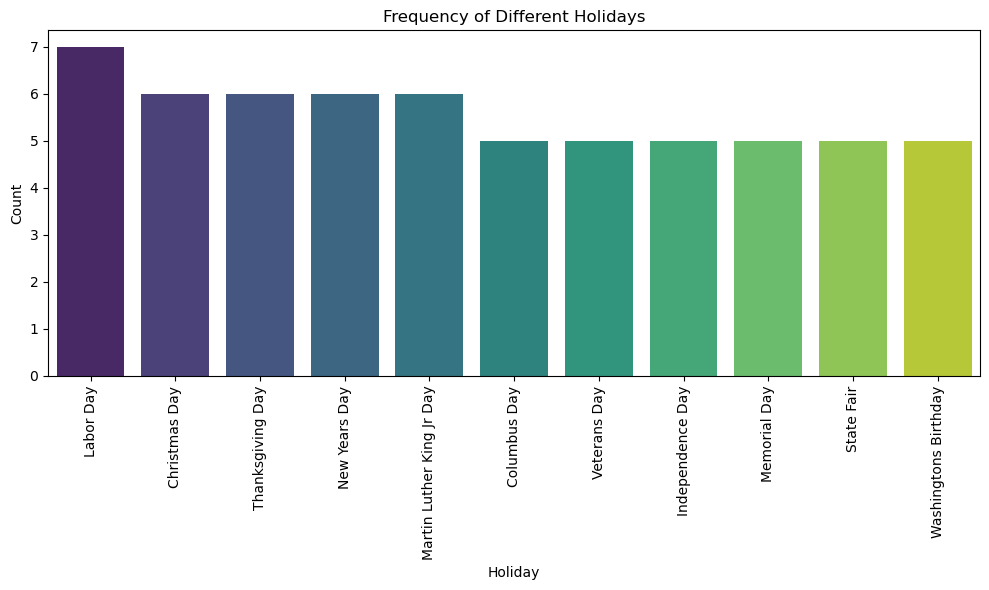

In [18]:
holidays_df = df[df['holiday'] != 'None']

# Count occurrences of each holiday
holiday_counts = holidays_df['holiday'].value_counts()

# Create a bar plot for holidays
plt.figure(figsize=(10, 6))
sns.barplot(x=holiday_counts.index, y=holiday_counts.values, palette='viridis')
plt.xlabel('Holiday')
plt.ylabel('Count')
plt.title('Frequency of Different Holidays')
plt.xticks(rotation=90)
plt.tight_layout()

# Show the plot
plt.show()

**2. Histogram of Temperature Distribution**

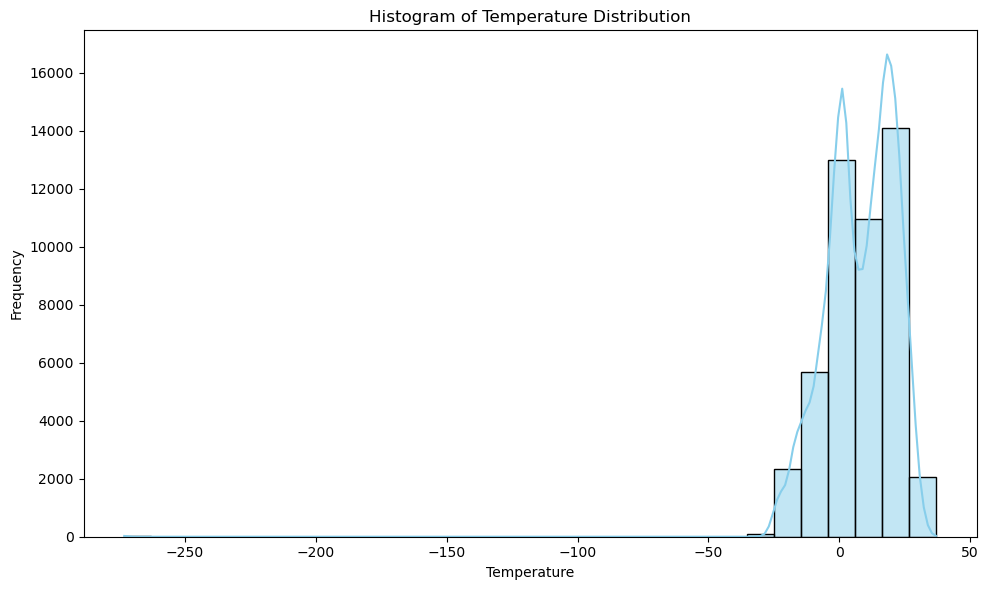

In [19]:
plt.figure(figsize=(10, 6))

sns.histplot(df['temp_celsius'], bins=30, color='skyblue', edgecolor='black',kde = 'True')

plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Histogram of Temperature Distribution')

plt.tight_layout()
plt.show()

**3. Bar Plot of Average Traffic Volume by Weather Description**

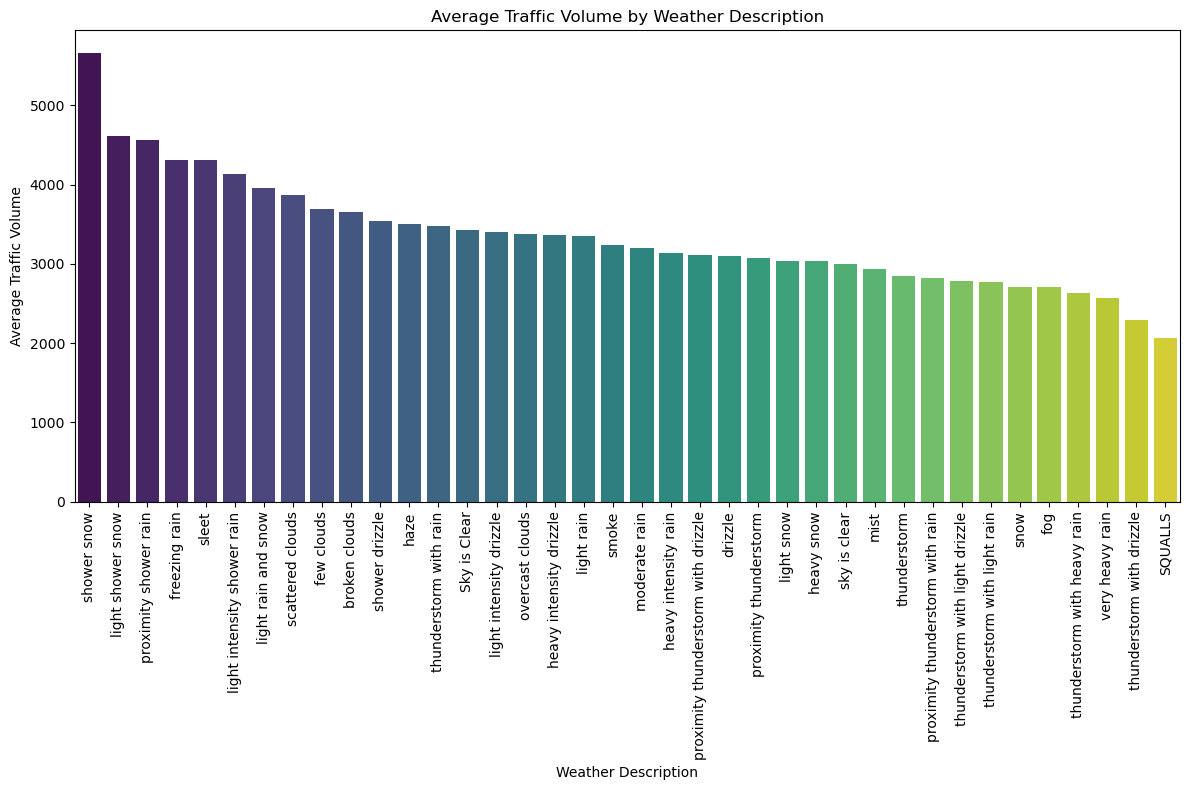

In [20]:
# Create a pivot table for average traffic volume
pivot_table = df.pivot_table(values='traffic_volume', index='weather_description', aggfunc='mean')

# Reset index to use for plotting
pivot_table = pivot_table.reset_index()

# Sort the pivot table by 'traffic_volume' in descending order
pivot_table_sorted = pivot_table.sort_values(by='traffic_volume', ascending=False)

plt.figure(figsize=(12, 8))

# Create a bar plot with sorted data
sns.barplot(x='weather_description', y='traffic_volume', data=pivot_table_sorted, palette='viridis')

plt.xticks(rotation=90)
plt.xlabel('Weather Description')
plt.ylabel('Average Traffic Volume')
plt.title('Average Traffic Volume by Weather Description')

plt.tight_layout()
plt.show()

**4. Boxplot of Temperature by Weather Main**

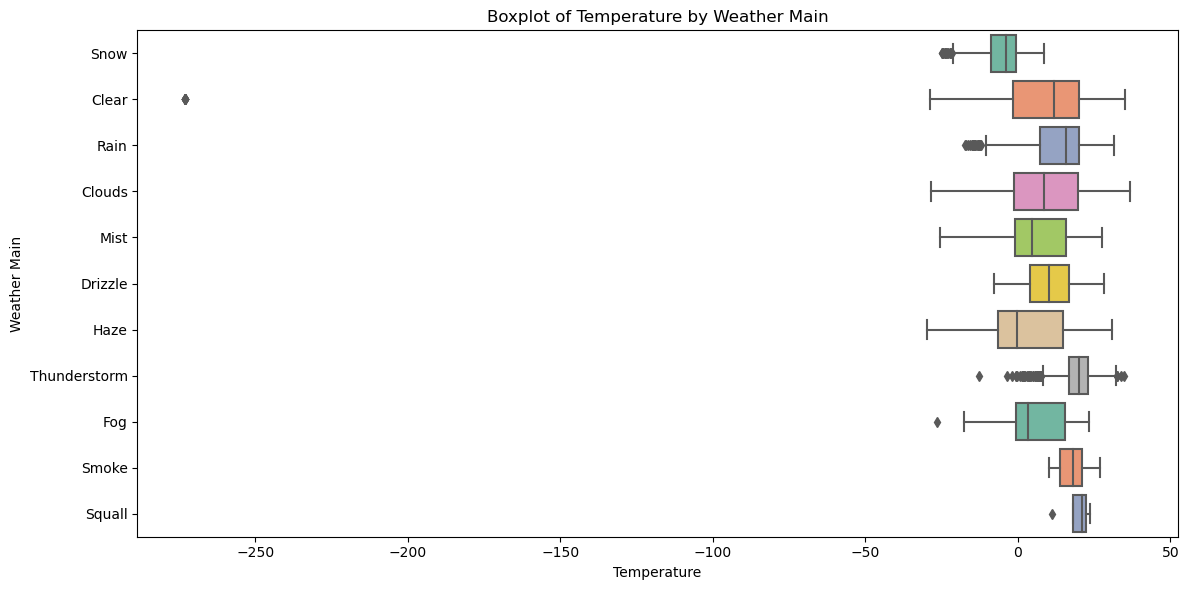

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Create a horizontal boxplot
sns.boxplot(x='temp_celsius', y='weather_main', data=df, palette='Set2')

plt.xlabel('Temperature')
plt.ylabel('Weather Main')
plt.title('Boxplot of Temperature by Weather Main')

plt.tight_layout()
plt.show()


**5. Average Traffic Volume by Holiday**

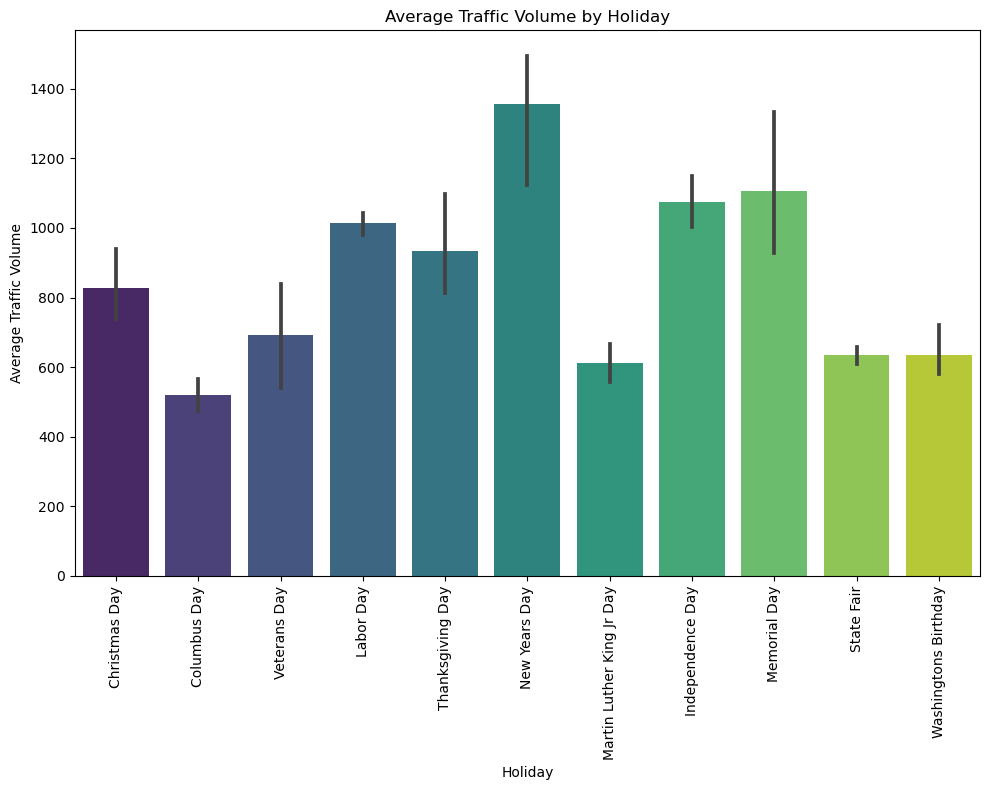

In [22]:
plt.figure(figsize=(10, 8))

sns.barplot(x='holiday', y='traffic_volume', data=holidays_df, palette='viridis')

plt.xticks(rotation=90)

plt.title('Average Traffic Volume by Holiday')
plt.xlabel('Holiday')
plt.ylabel('Average Traffic Volume')

plt.tight_layout()

plt.show()

## Data Preprocessing

In [23]:
traffic_data = df.copy()

traffic_data.head()

,_id,holiday,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,temp_celsius
0,8748e5b7-5940-4e81-88e5-b759407e8142,None,0.00,0.0,75,Snow,heavy snow,2013-02-20 02:00:00,220,-14.26
1,1da8337e-2569-4208-a833-7e256942089d,None,0.00,0.0,1,Clear,sky is clear,2018-09-09 23:00:00,996,14.86
2,87ae4c94-264b-4e42-ae4c-94264b9e426a,None,0.76,0.0,64,Rain,moderate rain,2013-07-31 01:00:00,402,17.50
3,ecce0631-32ee-4500-8e06-3132eea5008a,None,0.00,0.0,75,Clouds,broken clouds,2018-09-09 11:00:00,4273,17.63
4,346a7b77-6382-4830-aa7b-7763825830fd,None,0.00,0.0,1,Clear,sky is clear,2016-07-09 19:00:00,2903,26.16


### Encoding for Categorical Variables

In [24]:
label_encoder_main = LabelEncoder()
label_encoder_desc = LabelEncoder()

# Fit and transform 'weather_main'
traffic_data['weather_main'] = label_encoder_main.fit_transform(traffic_data['weather_main'])

# Fit and transform 'weather_description'
traffic_data['weather_description'] = label_encoder_desc.fit_transform(traffic_data['weather_description'])

In [25]:
traffic_data.head()

,_id,holiday,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume,temp_celsius
0,8748e5b7-5940-4e81-88e5-b759407e8142,None,0.00,0.0,75,8,10,2013-02-20 02:00:00,220,-14.26
1,1da8337e-2569-4208-a833-7e256942089d,None,0.00,0.0,1,0,27,2018-09-09 23:00:00,996,14.86
2,87ae4c94-264b-4e42-ae4c-94264b9e426a,None,0.76,0.0,64,6,18,2013-07-31 01:00:00,402,17.50
3,ecce0631-32ee-4500-8e06-3132eea5008a,None,0.00,0.0,75,1,2,2018-09-09 11:00:00,4273,17.63
4,346a7b77-6382-4830-aa7b-7763825830fd,None,0.00,0.0,1,0,27,2016-07-09 19:00:00,2903,26.16


### Dropping Redundant Columns

In [26]:
traffic_data = traffic_data.drop(['_id','rain_1h','snow_1h','weather_description'], axis=1)

# Display the updated DataFrame to confirm the columns have been removed
traffic_data.head()

,holiday,clouds_all,weather_main,date_time,traffic_volume,temp_celsius
0,None,75,8,2013-02-20 02:00:00,220,-14.26
1,None,1,0,2018-09-09 23:00:00,996,14.86
2,None,64,6,2013-07-31 01:00:00,402,17.50
3,None,75,1,2018-09-09 11:00:00,4273,17.63
4,None,1,0,2016-07-09 19:00:00,2903,26.16


**The weather_description column provides an elaborated description of the weather conditions, which duplicates information already contained in the weather_main column.**

### Outlier Detection & Treatment

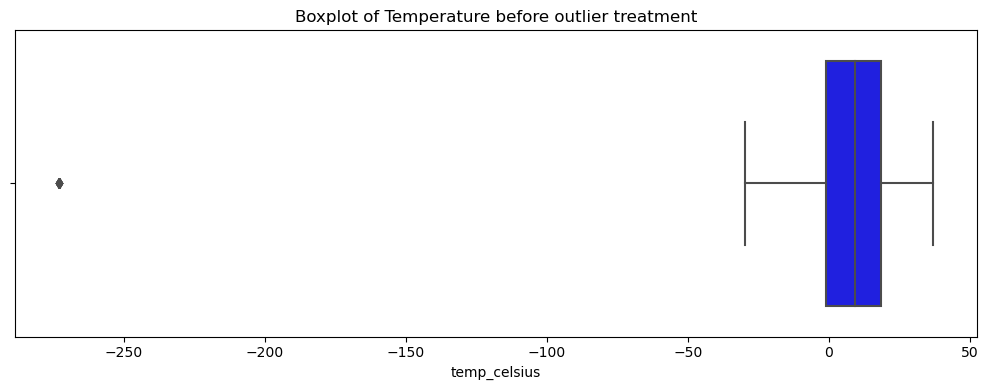

In [27]:
# Set up the matplotlib figure with a 1x1 configuration
plt.figure(figsize=(10, 4))

# Boxplot for 'temp' before outlier treatment
sns.boxplot(x=traffic_data['temp_celsius'], color='blue')

# Set the title for the plot
plt.title('Boxplot of Temperature before outlier treatment')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

**As shown in boxplot above, there is an anomaly in the data as the temperature of more than -250 Celcius is not possible. Let's remove the outliers.**

In [28]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile) for the 'temp' column
Q1 = traffic_data['temp_celsius'].quantile(0.25)
Q3 = traffic_data['temp_celsius'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define the outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = traffic_data[(traffic_data['temp_celsius'] < lower_bound) | (traffic_data['temp_celsius'] > upper_bound)]

# Number of outliers
num_outliers = outliers.shape[0]

# Print the number of outliers
print(f"Number of outliers in 'temp_celsius': {num_outliers}")

Number of outliers in 'temp_celsius': 10


In [29]:
# Remove outliers from the DataFrame
traffic_data = traffic_data[(traffic_data['temp_celsius'] >= lower_bound) & (traffic_data['temp_celsius'] <= upper_bound)]

# Display the cleaned DataFrame
traffic_data.head()

,holiday,clouds_all,weather_main,date_time,traffic_volume,temp_celsius
0,None,75,8,2013-02-20 02:00:00,220,-14.26
1,None,1,0,2018-09-09 23:00:00,996,14.86
2,None,64,6,2013-07-31 01:00:00,402,17.50
3,None,75,1,2018-09-09 11:00:00,4273,17.63
4,None,1,0,2016-07-09 19:00:00,2903,26.16


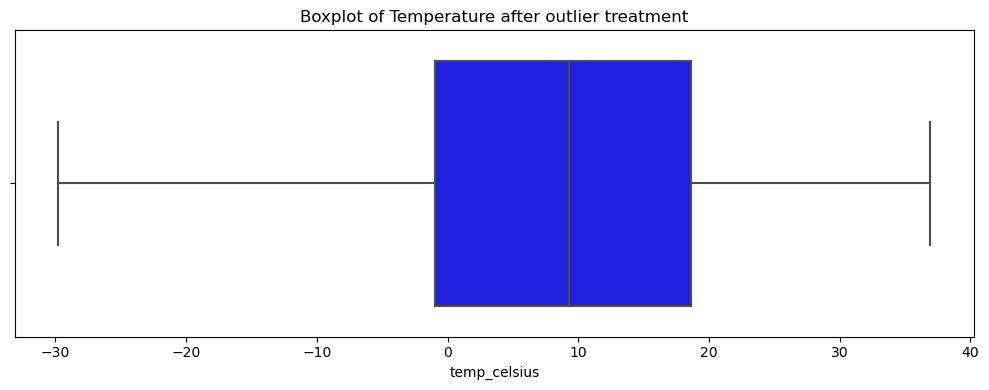

In [30]:
# Set up the matplotlib figure with a 1x1 configuration
plt.figure(figsize=(10, 4))

# Boxplot for 'temp' before outlier treatment
sns.boxplot(x=traffic_data['temp_celsius'], color='blue')

# Set the title for the plot
plt.title('Boxplot of Temperature after outlier treatment')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

## Feature Engineering

In [31]:
# Create 'holiday_flag' column: 1 if the holiday column contains a holiday, otherwise 0
traffic_data['holiday_flag'] = traffic_data['holiday'].apply(lambda x: 0 if x == 'None' else 1)

# Display the unique values in the 'holiday_flag' column to verify
print("Unique values in 'holiday_flag':", traffic_data['holiday_flag'].unique())

Unique values in 'holiday_flag': [0 1]


In [32]:
# Convert the 'date_time' column from object to datetime format
traffic_data['date_time'] = pd.to_datetime(traffic_data['date_time'])

# Extract the day of the month
traffic_data['day'] = traffic_data['date_time'].dt.day

# Extract the hour
traffic_data['hour'] = traffic_data['date_time'].dt.hour

<IPython.core.display.Javascript object>

In [33]:
#Drop the 'date_time' column from the DataFrame 'traffic_data'

traffic_data = traffic_data.drop('date_time', axis=1)

In [34]:
#Drop the 'holiday' column from the DataFrame 'traffic_data'
traffic_data = traffic_data.drop('holiday', axis=1)

In [35]:
# Copying to preserve the Original Data
traffic_data_cleaned = traffic_data.copy()
traffic_data_cleaned.head()

,clouds_all,weather_main,traffic_volume,temp_celsius,holiday_flag,day,hour
0,75,8,220,-14.26,0,20,2
1,1,0,996,14.86,0,9,23
2,64,6,402,17.50,0,31,1
3,75,1,4273,17.63,0,9,11
4,1,0,2903,26.16,0,9,19


## Feature Standardization 

In [36]:
from sklearn.preprocessing import StandardScaler

# List of numeric columns to standardize
columns_to_standardize = ['clouds_all', 'temp_celsius']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the selected columns
traffic_data_cleaned[columns_to_standardize] = scaler.fit_transform(traffic_data_cleaned[columns_to_standardize])

# Display the first few rows to confirm the changes
traffic_data_cleaned.head()

,clouds_all,weather_main,traffic_volume,temp_celsius,holiday_flag,day,hour
0,0.656899,8,220,-1.760439,0,20,2
1,-1.239909,0,996,0.530769,0,9,23
2,0.374941,6,402,0.738488,0,31,1
3,0.656899,1,4273,0.748717,0,9,11
4,-1.239909,0,2903,1.419871,0,9,19


In [45]:
import joblib
joblib.dump(scaler, 'scaler.pkl')  # Save the scaler to a file

['scaler.pkl']

## Model Development

### Train Test Split

In [37]:
X = traffic_data_cleaned.drop(columns=['traffic_volume'])
y = traffic_data_cleaned['traffic_volume']

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Check the shapes of the splits
print(f"Training feature set shape: {X_train.shape}")
print(f"Testing feature set shape: {X_test.shape}")
print(f"Training target set shape: {y_train.shape}")
print(f"Testing target set shape: {y_test.shape}")

Training feature set shape: (38555, 6)
Testing feature set shape: (9639, 6)
Training target set shape: (38555,)
Testing target set shape: (9639,)


### Model Training

In [39]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'AdaBoost': AdaBoostRegressor(random_state=42),
    'GradientBoost': GradientBoostingRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_seed=42),
    'XGBoost': XGBRegressor(random_state=42)
}

# List to store r2_score
r2_scores = []

# Cross-validation
for model_name, model in models.items():
    data_pipeline = Pipeline(steps=[
        ('model', model)
    ])
    
    # R² Score
    r2_score = cross_val_score(data_pipeline, X_train, y_train, cv=KFold(n_splits=10), 
                                scoring='r2', n_jobs=-1).mean()
    r2_scores.append(r2_score)

# Display the results
for model_name, r2 in zip(models.keys(), r2_scores):
    print(f"{model_name}: R² = {r2:.4f}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Linear Regression: R² = 0.1389
AdaBoost: R² = 0.7353
GradientBoost: R² = 0.7817
RandomForest: R² = 0.8102
CatBoost: R² = 0.8067
XGBoost: R² = 0.8103


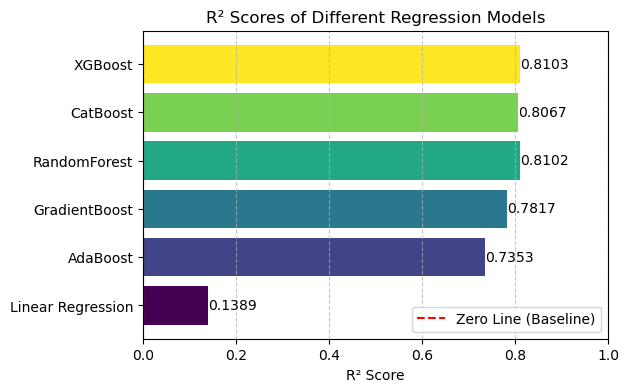

In [40]:
# Data for visualization
model_names = list(models.keys())
r2_scores = r2_scores  

# Define a list of colors for each model
colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))  

# Create a bar chart
plt.figure(figsize=(6, 4))
bars = plt.barh(model_names, r2_scores, color=colors)
plt.xlabel('R² Score')
plt.title('R² Scores of Different Regression Models')
plt.xlim(0, 1)  
plt.axvline(x=0, color='red', linestyle='--', label='Zero Line (Baseline)')
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Add value labels to each bar with exact values
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{bar.get_width():.4f}', va='center')

# Show the plot
plt.show()


**XGBoost achieved the highest R² score of 0.8103, and we will now proceed with hyperparameter tuning for the models to optimize their performance further.**

## Model Optimization

In [41]:
param_grid = {
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.2],
    'model__max_depth': [3, 5, 7],
    'model__subsample': [0.8, 1.0],
    'model__colsample_bytree': [0.8, 1.0],
}

# Create a pipeline for the XGBoost model
data_pipeline = Pipeline(steps=[
    ('model', XGBRegressor(random_state=42))
])

# Set up GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=data_pipeline, 
                           param_grid=param_grid,
                           scoring='r2', 
                           cv=KFold(n_splits=10), 
                           n_jobs=-1, 
                           verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Output the results
print("Best Parameters:", best_params)
print("Best R² Score from Grid Search:", best_score)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Best Parameters: {'model__colsample_bytree': 1.0, 'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 300, 'model__subsample': 1.0}
Best R² Score from Grid Search: 0.8252171456813813


**After Hyperparameter Tuning, the R² Score of the XGBoost Model Improved from 0.8103 to 0.8252.**

## Model Testing

In [42]:
# Create a final pipeline with the best model
final_pipeline = Pipeline(steps=[
    ('model', grid_search.best_estimator_.named_steps['model'])  # Use the best model from grid search
])

# Fit the final pipeline on the training data
final_pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = final_pipeline.predict(X_test)


# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmae = np.sqrt(mean_absolute_error(y_test, y_pred))

# Output the results
print("Test Set Performance:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Absolute Error (RMAE): {rmae:.4f}")

Test Set Performance:
Mean Absolute Error (MAE): 540.8588
Root Mean Absolute Error (RMAE): 23.2564


## Exporting the Best Model for Deployment

In [43]:
import pickle

best_model = grid_search.best_estimator_  

model_filename = 'xgboost_model.pkl'

# Save the model to a file
with open(model_filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"Model saved as {model_filename}")


Model saved as xgboost_model.pkl
